### Домашняя работа № 2, Н.В.Кривоногов

In [1]:
import pandas as pd

Наши новости

https://drive.google.com/file/d/1O7OYgAejpiot6xic0_k6L8lHtvhuswRV/view?usp=share_link

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [4]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [5]:
#! pip install razdel

In [6]:
# ! pip install pymorphy2

In [7]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [8]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [9]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [10]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [11]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

C:\Users\Николай\AppData\Local\Temp\ipykernel_9064\2296537027.py:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 58.4 s


In [12]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 6min 45s


А теперь в 3 строчки обучим нашу модель

In [13]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [14]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [15]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 1min 28s


In [16]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [17]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(5, 0.04303415), (20, 0.93630666)]

In [18]:
x=lda.show_topics(num_topics=25, num_words=10,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: год это млн рубль который цена млрд рынок первый мочь
topic_1: определение методика резерв горожанин сражение донбасс мастеркласс артист украсить джонс
topic_2: банк год доход который агентство американский это данные инвестиция применение
topic_3: миссия русский который космос аэропорт рейс человек это научный nn
topic_4: суд дело год который уголовный лицо рубль преступление это гражданин
topic_5: риск фильм спрос форум сообщество лётчик железнодорожный апрель год работа
topic_6: высота километр параметр передовой трата мэрия постановка метр секунда люксембург
topic_7: год это который также россия сша nn российский страна время
topic_8: край специальный язык диапазон компьютер армения перевод кремль распространяться звонок
topic_9: ск диск негативно гагарин сближение ухо золотой победитель атмосферный выложить
topic_10: исследование который год смерть свой ребёнок это человек мочь автор
topic_11: граница район транспорт разместить министерство напомнить продукция маршрут пит

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [19]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [20]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.0,0.892282,0.000000,0.052761,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
1,4896,0.000000,0.0,0.000000,0.000000,0.058415,0.000000,0.0,0.0,0.000000,...,0.805396,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
2,4897,0.000000,0.0,0.000000,0.000000,0.000000,0.043025,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.936316,0.0,0.000000,0.0,0.0
3,4898,0.105255,0.0,0.244127,0.062982,0.000000,0.000000,0.0,0.0,0.000000,...,0.032077,0.0,0.0,0.000000,0.0,0.462859,0.0,0.018687,0.0,0.0
4,4899,0.000000,0.0,0.186068,0.000000,0.000000,0.190550,0.0,0.0,0.453546,...,0.000000,0.0,0.0,0.146458,0.0,0.000000,0.0,0.000000,0.0,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [21]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [22]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [23]:
doc_dict[293622]

array([0.09263797, 0.        , 0.        , 0.        , 0.07771471,
       0.        , 0.        , 0.22732416, 0.        , 0.02115524,
       0.        , 0.02074105, 0.        , 0.        , 0.11357774,
       0.        , 0.11141697, 0.        , 0.        , 0.        ,
       0.25228876, 0.        , 0.01948829, 0.        , 0.05455125])

In [24]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [25]:
get_user_embedding(user_articles_list)

array([0.07411667, 0.        , 0.02213598, 0.00257712, 0.11201058,
       0.        , 0.        , 0.24370528, 0.        , 0.02633163,
       0.03689812, 0.        , 0.01748404, 0.        , 0.03844957,
       0.01497941, 0.01759506, 0.00555161, 0.22256055, 0.08079326,
       0.0169135 , 0.02633485, 0.        , 0.01329792, 0.0184735 ])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [26]:
#users['articles'].iloc[33]

In [27]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [28]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.023971,0.0,0.020970,0.016794,0.049066,0.005206,0.000000,0.366364,0.000000,...,0.038221,0.103065,0.0,0.054516,0.000000,0.055729,0.000000,0.010202,0.009798,0.058707
1,u108690,0.077525,0.0,0.006166,0.000000,0.061248,0.005054,0.000000,0.275283,0.000000,...,0.021520,0.074903,0.0,0.131150,0.092777,0.060365,0.000000,0.002173,0.003918,0.024649
2,u108339,0.039675,0.0,0.035240,0.009605,0.070785,0.002229,0.002609,0.298380,0.001747,...,0.083561,0.060029,0.0,0.132272,0.045647,0.010270,0.013427,0.000000,0.047788,0.031526


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [29]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [30]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.023971,0.0,0.020970,0.016794,0.049066,0.005206,0.000000,0.366364,0.000000,...,0.103065,0.0,0.054516,0.000000,0.055729,0.000000,0.010202,0.009798,0.058707,0
1,u108690,0.077525,0.0,0.006166,0.000000,0.061248,0.005054,0.000000,0.275283,0.000000,...,0.074903,0.0,0.131150,0.092777,0.060365,0.000000,0.002173,0.003918,0.024649,1
2,u108339,0.039675,0.0,0.035240,0.009605,0.070785,0.002229,0.002609,0.298380,0.001747,...,0.060029,0.0,0.132272,0.045647,0.010270,0.013427,0.000000,0.047788,0.031526,1


In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [32]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [33]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [34]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.15734392, 0.17622207, 0.31711638, 0.15584851, 0.06668657,
       0.1220567 , 0.09029281, 0.03553427, 0.1467074 , 0.09122999])

In [35]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [36]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.242678, F-Score=0.645, Precision=0.641, Recall=0.649


In [37]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1666   89]
 [  87  158]]


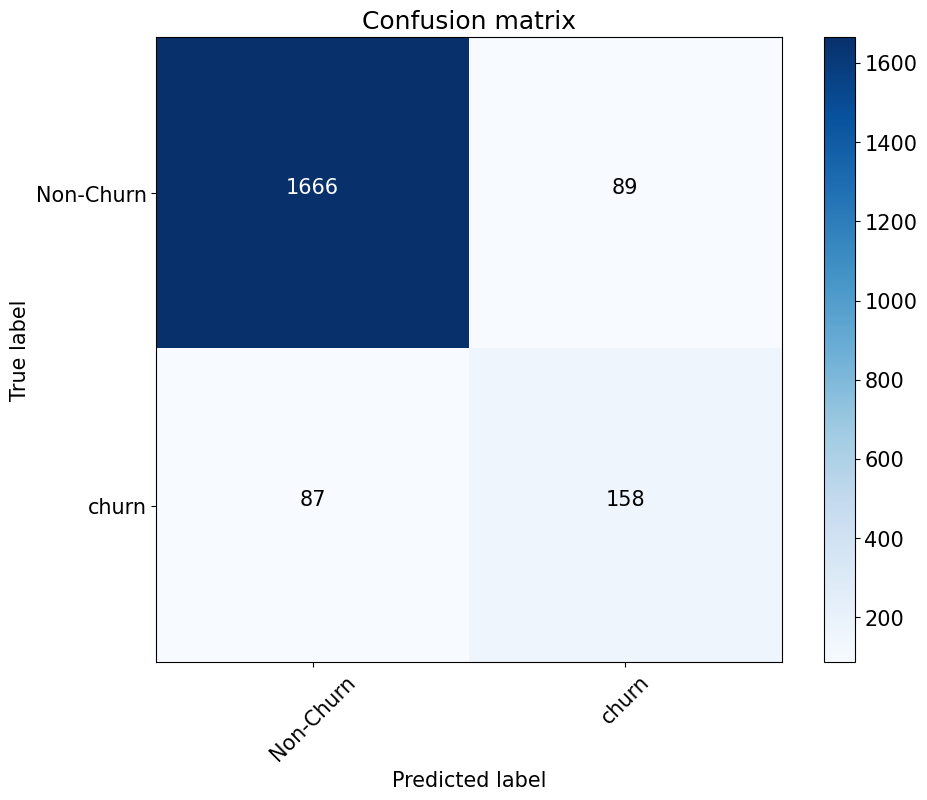

In [38]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [39]:
roc_auc_score = roc_auc_score(y_test, preds)
roc_auc_score

0.9359218559218558

In [40]:
print(f'Метрика roc auc для mean: {roc_auc_score}')
print(f'Метрика precision для mean: {precision[ix]}')
print(f'Метрика recall для mean: {recall[ix]}')
print(f'Метрика f_score для mean: {fscore[ix]}')

Метрика roc auc для mean: 0.9359218559218558
Метрика precision для mean: 0.6411290322580645
Метрика recall для mean: 0.6489795918367347
Метрика f_score для mean: 0.6450304259634889


В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score

In [65]:
user_articles_list_median = users['articles'].iloc[33]

def get_user_embedding_median(user_articles_list_median):
    user_articles_list = eval(user_articles_list_median)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0) # медиана
    return user_vector

In [66]:
get_user_embedding_median(user_articles_list_median)

array([0.00993014, 0.        , 0.0144968 , 0.        , 0.0079814 ,
       0.        , 0.        , 0.19680268, 0.        , 0.        ,
       0.02040932, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.28473268, 0.0181929 ,
       0.01316083, 0.        , 0.        , 0.        , 0.        ])

In [67]:
user_embeddings_median = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings_median.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_median['uid'] = users['uid'].values
user_embeddings_median = user_embeddings_median[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.377926,0.0,...,0.000000,0.096575,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.015845
1,u108690,0.065856,0.0,0.000000,0.0,0.000000,0.0,0.0,0.245105,0.0,...,0.008199,0.046574,0.0,0.110227,0.085286,0.048333,0.0,0.0,0.000000,0.021534
2,u108339,0.011787,0.0,0.032694,0.0,0.068363,0.0,0.0,0.314831,0.0,...,0.030835,0.054358,0.0,0.099711,0.045475,0.009157,0.0,0.0,0.012235,0.019193


In [68]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [69]:
X_median = pd.merge(user_embeddings_median, target, 'left')
X_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.377926,0.0,...,0.096575,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.015845,0
1,u108690,0.065856,0.0,0.000000,0.0,0.000000,0.0,0.0,0.245105,0.0,...,0.046574,0.0,0.110227,0.085286,0.048333,0.0,0.0,0.000000,0.021534,1
2,u108339,0.011787,0.0,0.032694,0.0,0.068363,0.0,0.0,0.314831,0.0,...,0.054358,0.0,0.099711,0.045475,0.009157,0.0,0.0,0.012235,0.019193,1


In [70]:
#разделим данные на train/test
X_median_train, X_median_test, y_median_train, y_median_test = train_test_split(X_median[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_median['churn'], random_state=0)

In [71]:
logreg_median = LogisticRegression()
#обучим 
logreg_median.fit(X_median_train, y_median_train)

LogisticRegression()

In [72]:
#наши прогнозы для тестовой выборки
preds_median = logreg_median.predict_proba(X_median_test)[:, 1]
preds_median[:10]

array([0.08816839, 0.10185311, 0.30010845, 0.27716454, 0.05919643,
       0.05797187, 0.18056056, 0.07408639, 0.108408  , 0.21340528])

In [73]:
precision_median, recall_median, thresholds_median = precision_recall_curve(y_median_test, preds_median)
fscore_median = (2 * precision_median * recall_median) / (precision_median + recall_median)
# locate the index of the largest f score
ix_median = np.argmax(fscore_median)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_median[ix_median], 
                                                                        fscore_median[ix_median],
                                                                        precision_median[ix_median],
                                                                        recall_median[ix_median]))

Best Threshold=0.235449, F-Score=0.724, Precision=0.682, Recall=0.771


Confusion matrix, without normalization
[[1667   88]
 [  57  188]]


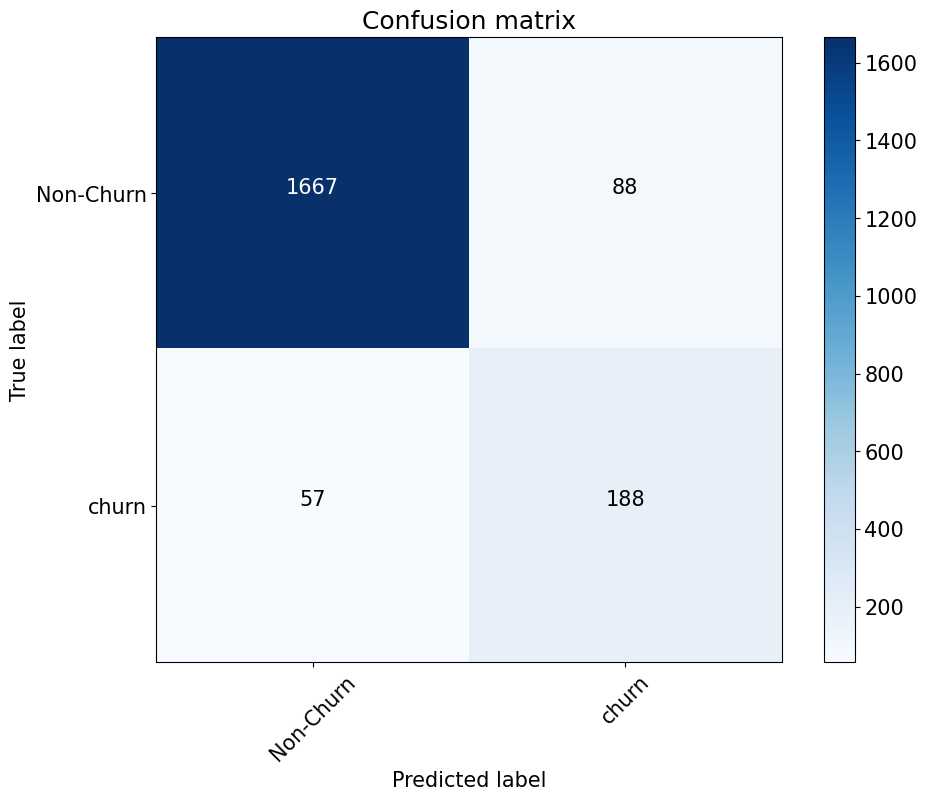

In [74]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_median_test, preds_median>thresholds_median[ix_median])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [80]:
# почему-то выдает ошибку: 
# TypeError: 'numpy.float64' object is not callable

# roc_auc_median = roc_auc_score(y_median_test, preds_median)
# roc_auc_median

In [81]:
# print(f'Метрика roc auc для median: {roc_auc_median}')
print(f'Метрика precision для median: {precision_median[ix_median]}')
print(f'Метрика recall для median: {recall_median[ix_median]}')
print(f'Метрика f_score для median: {fscore_median[ix_median]}')

Метрика precision для median: 0.6823104693140795
Метрика recall для median: 0.7714285714285715
Метрика f_score для median: 0.7241379310344828


Повторить п.2, но используя уже не медиану, а max

In [82]:
user_articles_list_max = users['articles'].iloc[33]

def get_user_embedding_max(user_articles_list_max):
    user_articles_list = eval(user_articles_list_max)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0) # максимальное
    return user_vector

In [83]:
get_user_embedding_max(user_articles_list_max)

array([0.33699822, 0.        , 0.066792  , 0.01546272, 0.51518601,
       0.        , 0.        , 0.40348288, 0.        , 0.1579898 ,
       0.109035  , 0.        , 0.05662327, 0.        , 0.1431568 ,
       0.06166966, 0.10557036, 0.03330966, 0.31908342, 0.31700397,
       0.04052123, 0.15800908, 0.        , 0.0797875 , 0.09102894])

In [84]:
user_embeddings_max = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings_max.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_max['uid'] = users['uid'].values
user_embeddings_max = user_embeddings_max[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.092638,0.0,0.103997,0.100764,0.216680,0.031233,0.000000,0.647215,0.000000,...,0.229327,0.265028,0.0,0.237055,0.000000,0.252289,0.00000,0.041724,0.058790,0.266001
1,u108690,0.195137,0.0,0.036994,0.000000,0.259312,0.030325,0.000000,0.476437,0.000000,...,0.078366,0.195036,0.0,0.297370,0.160176,0.124803,0.00000,0.013038,0.023508,0.065805
2,u108339,0.134608,0.0,0.085474,0.041333,0.157477,0.013374,0.015655,0.338948,0.010479,...,0.274917,0.143024,0.0,0.345004,0.094673,0.022373,0.05212,0.000000,0.132093,0.084677


In [85]:
X_max = pd.merge(user_embeddings_max, target, 'left')
X_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.092638,0.0,0.103997,0.100764,0.216680,0.031233,0.000000,0.647215,0.000000,...,0.265028,0.0,0.237055,0.000000,0.252289,0.00000,0.041724,0.058790,0.266001,0
1,u108690,0.195137,0.0,0.036994,0.000000,0.259312,0.030325,0.000000,0.476437,0.000000,...,0.195036,0.0,0.297370,0.160176,0.124803,0.00000,0.013038,0.023508,0.065805,1
2,u108339,0.134608,0.0,0.085474,0.041333,0.157477,0.013374,0.015655,0.338948,0.010479,...,0.143024,0.0,0.345004,0.094673,0.022373,0.05212,0.000000,0.132093,0.084677,1


In [86]:

#разделим данные на train/test
X_max_train, X_max_test, y_max_train, y_max_test = train_test_split(X_max[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_max['churn'], random_state=0)

In [87]:
logreg_max = LogisticRegression()
#обучим 
logreg_max.fit(X_max_train, y_max_train)

LogisticRegression()

In [88]:
#наши прогнозы для тестовой выборки
preds_max = logreg_max.predict_proba(X_max_test)[:, 1]
preds_max[:10]

array([0.14132388, 0.00295907, 0.58087809, 0.05003504, 0.06582685,
       0.06861418, 0.03480075, 0.03204554, 0.02735669, 0.03529434])

In [89]:
precision_max, recall_max, thresholds_max = precision_recall_curve(y_max_test, preds_max)
fscore_max = (2 * precision_max * recall_max) / (precision_max + recall_max)
# locate the index of the largest f score
ix_max = np.argmax(fscore_max)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_max[ix_max], 
                                                                        fscore_max[ix_max],
                                                                        precision_max[ix_max],
                                                                        recall_max[ix_max]))

Best Threshold=0.327813, F-Score=0.755, Precision=0.726, Recall=0.788


Confusion matrix, without normalization
[[1682   73]
 [  53  192]]


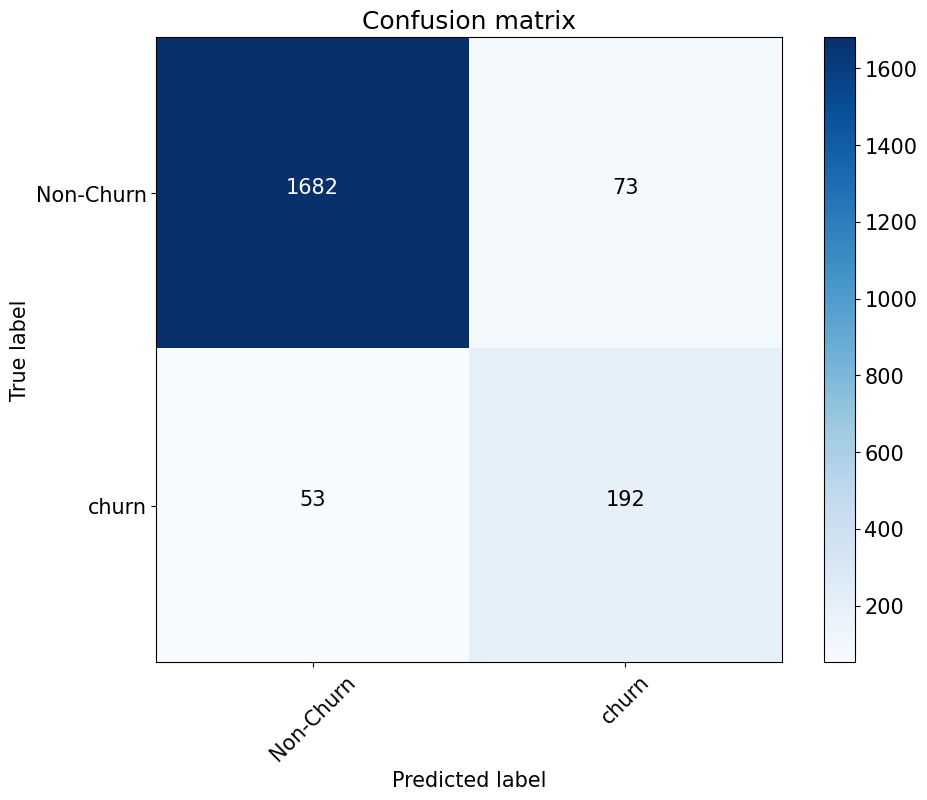

In [90]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_max_test, preds_max>thresholds_max[ix_max])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [92]:
# почему-то выдает ошибку: 
# TypeError: 'numpy.float64' object is not callable

# roc_auc_max = roc_auc_score(y_max_test, preds_max)
# roc_auc_max 

In [93]:
# print(f'Метрика roc auc для max: {roc_auc_max}')
print(f'Метрика precision для median: {precision_max[ix_max]}')
print(f'Метрика recall для median: {recall_max[ix_max]}')
print(f'Метрика f_score для median: {fscore_max[ix_max]}')

Метрика precision для median: 0.7255639097744361
Метрика recall для median: 0.7877551020408163
Метрика f_score для median: 0.7553816046966733


Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max по метрикам precision, recall, f_score

In [95]:
results = {'precision': [precision[ix], precision_median[ix_median], precision_max[ix_max]], 
           'recall': [recall[ix], recall_median[ix_median], recall_max[ix_max]], 
           'f_score': [fscore[ix], fscore_median[ix_median], fscore_max[ix_max]]} 
 
df_results = pd.DataFrame(results, index =['mean', 'median', 'max']) 
df_results

,precision,recall,f_score
mean,0.641129,0.648980,0.645030
median,0.682310,0.771429,0.724138
max,0.725564,0.787755,0.755382


Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

Исходя из полученных данных, можно заметить улучшение (рост) метрик при использовании соответственно mean, median, max. 
Вариант с max - лучший в качестве метода получения эмбеддингов пользователей. Он выглядит наиболее сбалансированным по параметрам precision, recall, и f_score. 

Представим матрицу векторов статей пользователя. Столбцы - это статьи, строки - темы. Если у нас имеется несколько статей, с большой вероятностью отнесенных к определенной теме, а в остальных статьях будут нули на этой теме, то вместо того, чтобы четко соотнести интерес пользователя к этой теме, мы наоборот занижаем это значение взятием среднего. Поэтому результат получается самым худшим.

При взятии медианы мы часто зануляем значение "интереса" пользователя к тематике, если статей этой тематики недостаточно много. Но при этом хорошо улавливаем основные тематики интересов пользователя.

Как показал эксперимент, лучшим методом оказалось взятие максимума. При этом мы не уменьшаем и не зануляем средние и мелкие блоки тем и так же хорошо улавливаем крупные. То есть при таком методе подсчета можно сказать, что модель хорошо улавливает и основные интересы пользователя, но также отмечает интерес к малочисленным, но хорошо кластеризованным статьям.